In [1]:
import scipy.io
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
import dgl
import torch
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
datasets = {
    "Bitcoin Alpha": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-alpha.mtx",
    "Bitcoin OTC": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-otc.mtx",
    "Epinions": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx",
    "Slashdot": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-Slashdot081106.mtx"
}


In [3]:
graphs = {}

for name, path in datasets.items():
    print(f" Loading dataset: {name} ...")
    mtx_data = scipy.io.mmread(path)
    G = nx.from_scipy_sparse_array(mtx_data, create_using=nx.Graph)
    graphs[name] = G
    print(f"{name} - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}\n")

 Loading dataset: Bitcoin Alpha ...
Bitcoin Alpha - Nodes: 3783, Edges: 14124

 Loading dataset: Bitcoin OTC ...
Bitcoin OTC - Nodes: 5881, Edges: 21492

 Loading dataset: Epinions ...
Epinions - Nodes: 131828, Edges: 711783

 Loading dataset: Slashdot ...
Slashdot - Nodes: 77357, Edges: 468554



In [4]:
degree_distributions = {}

for name, G in graphs.items():
    
    degree_dict = dict(G.degree())
    degree_series = pd.Series(degree_dict)

    # Save degree distribution
    degree_df = pd.DataFrame({"Node": list(G.nodes), "Degree": degree_series})
    degree_df.to_csv(f"{name}_degree_distribution.csv", index=False)

    degree_distributions[name] = degree_series.describe()

# Convert results to DataFrame
degree_summary_df = pd.DataFrame(degree_distributions)
print("\n Summary of Degree Distributions:")
print(degree_summary_df)


 Summary of Degree Distributions:
       Bitcoin Alpha  Bitcoin OTC       Epinions      Slashdot
count    3783.000000  5881.000000  131828.000000  77357.000000
mean        7.467090     7.308961      10.798662     12.114069
std        20.055671    23.039354      51.573440     40.393764
min         1.000000     1.000000       1.000000      0.000000
25%         1.000000     1.000000       1.000000      1.000000
50%         2.000000     2.000000       1.000000      2.000000
75%         6.000000     5.000000       4.000000      8.000000
max       511.000000   795.000000    3558.000000   2537.000000


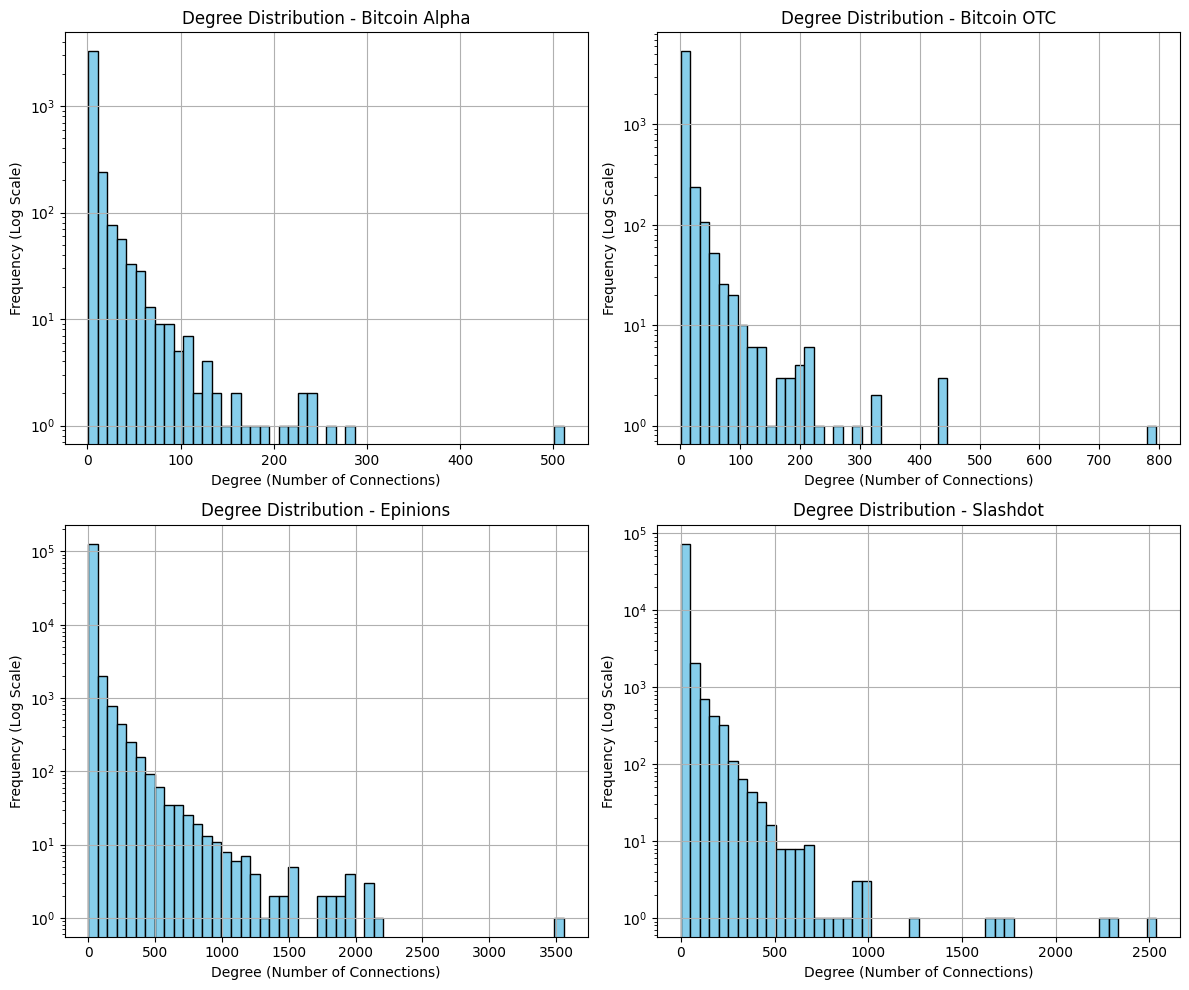

In [5]:
# Plot degree distributions for all datasets
plt.figure(figsize=(12, 10))

for i, (name, G) in enumerate(graphs.items(), 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    degree_sequence = [deg for _, deg in G.degree()]
    plt.hist(degree_sequence, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel("Degree (Number of Connections)")
    plt.ylabel("Frequency (Log Scale)")
    plt.title(f"Degree Distribution - {name}")
    plt.grid(True)

plt.tight_layout()
plt.savefig("degree_distributions_all.png", dpi=300)
plt.show()


Most nodes have a low degree --> The majority of nodes have very few connections (degree ≤ 10).
Few nodes have a high degree --> A small number of nodes have hundreds or thousands of connections

In [6]:
# Compute graph density for each dataset
for name, G in graphs.items():
    graph_density = nx.density(G)
    print(f"{name} - Number of Nodes: {G.number_of_nodes()}")
    print(f"{name} - Number of Edges: {G.number_of_edges()}")
    print(f"{name} - Graph Density: {graph_density:.4f}\n")



Bitcoin Alpha - Number of Nodes: 3783
Bitcoin Alpha - Number of Edges: 14124
Bitcoin Alpha - Graph Density: 0.0020

Bitcoin OTC - Number of Nodes: 5881
Bitcoin OTC - Number of Edges: 21492
Bitcoin OTC - Graph Density: 0.0012

Epinions - Number of Nodes: 131828
Epinions - Number of Edges: 711783
Epinions - Graph Density: 0.0001

Slashdot - Number of Nodes: 77357
Slashdot - Number of Edges: 468554
Slashdot - Graph Density: 0.0002



- Low density (0.0001 - 0.0020) means the networks are very sparse
- Most nodes do not have direct connections
- Larger networks (Epinions & Slashdot) have even lower densities

Potential features:

In [7]:
# List of potential feature files 
feature_files = {
    "Bitcoin Alpha Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-alpha_nodeid.mtx",
    "Bitcoin OTC Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-otc_nodeid.mtx"
}

In [8]:
# Try loading feature files
for name, path in feature_files.items():
    try:
        print(f"\nChecking features in: {name}")
        feature_data = scipy.io.mmread(path)
        
        # Convert to array and check shape
        feature_array = feature_data.toarray() if hasattr(feature_data, "toarray") else feature_data
        print(f"{name} - Shape: {feature_array.shape}")

        # Print first 5 node features (if applicable)
        if len(feature_array) > 0:
            print(f"First 5 Nodes' Features: {feature_array[:5]}")

    except Exception as e:
        print(f"Error loading {name}: {e}")


Checking features in: Bitcoin Alpha Node IDs
Error loading Bitcoin Alpha Node IDs: Line 1: Not a Matrix Market file. Missing banner.

Checking features in: Bitcoin OTC Node IDs
Error loading Bitcoin OTC Node IDs: Line 1: Not a Matrix Market file. Missing banner.


the values indicate just a numerical index for nodes, not meaningful attributes.

Bitcoin Alpha - High-Degree Nodes: 402
Bitcoin Alpha - Low-Degree Nodes: 1368

Bitcoin OTC - High-Degree Nodes: 597
Bitcoin OTC - Low-Degree Nodes: 2260

Epinions - High-Degree Nodes: 13193
Epinions - Low-Degree Nodes: 67325

Slashdot - High-Degree Nodes: 7821
Slashdot - Low-Degree Nodes: 28191



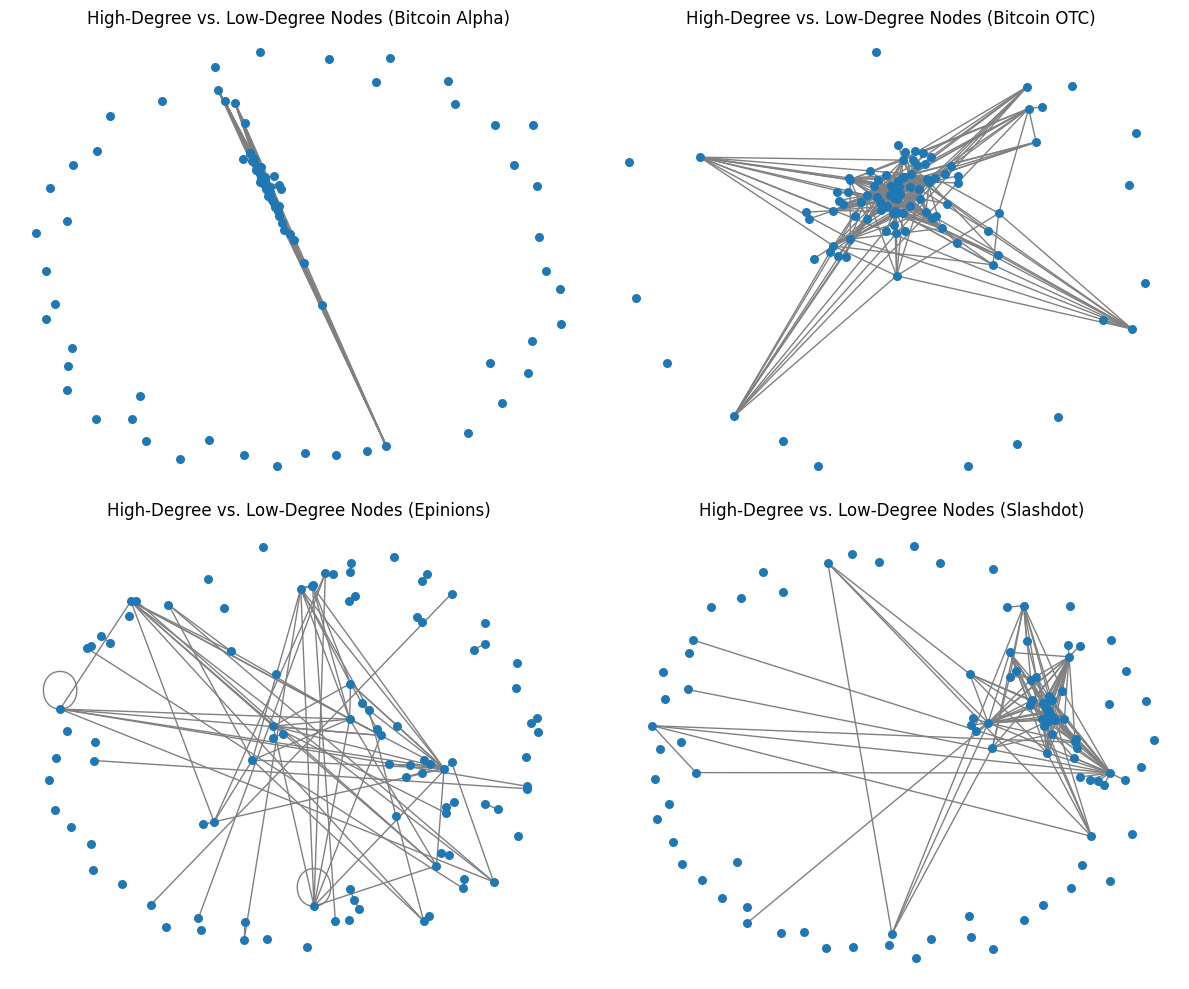

In [9]:
# Identify high-degree and low-degree nodes for each dataset
high_degree_nodes = {}
low_degree_nodes = {}

for name, G in graphs.items():
    degree_series = pd.Series(dict(G.degree()))

    # Define top 10% and bottom 10% threshold
    high_degree_threshold = degree_series.quantile(0.90)
    low_degree_threshold = degree_series.quantile(0.10)

    # Select nodes
    high_degree_nodes[name] = degree_series[degree_series >= high_degree_threshold].index
    low_degree_nodes[name] = degree_series[degree_series <= low_degree_threshold].index

    print(f"{name} - High-Degree Nodes: {len(high_degree_nodes[name])}")
    print(f"{name} - Low-Degree Nodes: {len(low_degree_nodes[name])}\n")

# Create a 2x2 plot for visualizing all datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, G) in enumerate(graphs.items()):
    # Sample 50 high-degree and 50 low-degree nodes
    subgraph_nodes = list(high_degree_nodes[name][:50]) + list(low_degree_nodes[name][:50])
    subG = G.subgraph(subgraph_nodes)

    # Plot the subgraph
    plt.sca(axes[i])
    nx.draw(subG, node_size=30, edge_color="gray")
    plt.title(f"High-Degree vs. Low-Degree Nodes ({name})")

plt.tight_layout()
plt.show()

- Bitcoin alpha -  high-degree nodes are concentrated in a central cluster, while low-degree nodes remain disconnected
- Bitcoin OTC - more concentrated core nodes with low-degree nodes still on the periphery
- Epinions - many cross-links, suggesting that both high and low-degree nodes interact more often
_ Slashdot - high-degree nodes form a dense core, while low-degree nodes are loosely attached

In [10]:
file_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"

with open(file_path, "r") as file:
    for _ in range(5):
        print(file.readline().strip())


%%MatrixMarket matrix coordinate integer general
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/SNAP/soc-sign-epinions
% name: SNAP/soc-sign-epinions


In [11]:
# Load graph from the .mtx file
def load_graph_data():
    mtx_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"
    
    # Read sparse matrix and convert to coordinate format
    mtx_data = scipy.io.mmread(mtx_path).tocoo()
    
    # Extract source, destination nodes & edge signs
    src = torch.tensor(mtx_data.row, dtype=torch.long)
    dst = torch.tensor(mtx_data.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx_data.data, dtype=torch.float)  # Edge weights (signed)

    # Create a DGL graph
    graph = dgl.graph((src, dst), num_nodes=max(src.max().item(), dst.max().item()) + 1)
    graph.edata['sign'] = edge_signs  # Store edge signs BEFORE adding self-loops

    graph = dgl.add_self_loop(graph)  # Add self-loops to avoid isolated nodes
    return graph


In [12]:
# Compute signed node features
def compute_signed_features(graph):
    num_nodes = graph.num_nodes()

    # Extract edges and their signs
    src, dst = graph.edges()
    edge_signs = graph.edata['sign']

    # Compute signed degrees
    pos_degree = torch.zeros(num_nodes)
    neg_degree = torch.zeros(num_nodes)

    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_degree[s] += 1
            pos_degree[d] += 1
        else:
            neg_degree[s] += 1
            neg_degree[d] += 1

    # Stack into a feature matrix
    node_features = torch.stack([pos_degree, neg_degree], dim=1)
    return node_features

In [13]:
# Load graph
graph = load_graph_data()
features = compute_signed_features(graph)  # Use signed degree features
print(graph)

Graph(num_nodes=131828, num_edges=973200,
      ndata_schemes={}
      edata_schemes={'sign': Scheme(shape=(), dtype=torch.float32)})


In [14]:
# Sample Hard Negative Edges
def sample_hard_negative_edges(graph, num_samples):
    neg_edges = []
    num_nodes = graph.num_nodes()

    while len(neg_edges) < num_samples:
        u = torch.randint(0, num_nodes, (num_samples,))
        v = torch.randint(0, num_nodes, (num_samples,))

        # Ensure they don't already exist as edges
        mask = ~graph.has_edges_between(u, v) 

        # Select only nodes with **similar degree values**
        degree_diff = torch.abs(graph.in_degrees(u) - graph.in_degrees(v))
        hard_mask = mask & (degree_diff < 5)  # Only allow similar-degree nodes

        sampled_edges = torch.stack((u[hard_mask], v[hard_mask]), dim=1)
        neg_edges.extend(sampled_edges.tolist())

    return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

# Get Real Edges
src, dst = graph.edges()
pos_edges = torch.stack((src, dst), dim=1)

# Sample Negative Edges using the New Function
num_edges = graph.num_edges()
neg_edges = sample_hard_negative_edges(graph, num_edges)

print(f"Sampled {len(neg_edges)} hard negative edges")

Sampled 973200 hard negative edges


In [15]:
# # Get positive and negative edges separately
# pos_edges = torch.stack((graph.edges()[0][graph.edata['sign'] > 0], 
#                          graph.edges()[1][graph.edata['sign'] > 0]), dim=1)

# neg_edges = torch.stack((graph.edges()[0][graph.edata['sign'] < 0], 
#                          graph.edges()[1][graph.edata['sign'] < 0]), dim=1)



In [16]:
# Train-test split
train_edges, test_edges = train_test_split(pos_edges, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(neg_edges, test_size=0.2, random_state=42)

In [17]:
# Combine positive and negative edges
train_edges = torch.cat([train_edges, train_neg], dim=0)
test_edges = torch.cat([test_edges, test_neg], dim=0)

In [18]:
# Labels (1 = real, 0 = fake)
train_labels = torch.cat([torch.ones(len(train_edges)//2), torch.zeros(len(train_edges)//2)])
test_labels = torch.cat([torch.ones(len(test_edges)//2), torch.zeros(len(test_edges)//2)])

print(f"Train Edges: {len(train_edges)}, Test Edges: {len(test_edges)}")
print(f"Train Negative Edges: {len(train_neg)}, Test Negative Edges: {len(test_neg)}")


Train Edges: 1557120, Test Edges: 389280
Train Negative Edges: 778560, Test Negative Edges: 194640


In [19]:
# GCN Encoder 
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        h = self.conv2(graph, h)
        return h

In [20]:
# MLP Decoder
class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edge_index):
        src, dst = edge_index[:, 0], edge_index[:, 1]
        h_concat = torch.cat([z[src], z[dst]], dim=1)
        z = F.relu(self.fc1(h_concat))
        return torch.sigmoid(self.fc2(z)).squeeze()


In [21]:
# Train GAE
class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GAE, self).__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)
    
    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

In [22]:
# Initialize model
hidden_dim = 128
out_dim = 64  
model = GAE(2, hidden_dim, out_dim)  # 2 features: pos-degree & neg-degree

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  
loss_fn = nn.BCELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(graph, features, train_edges)
    loss = loss_fn(output, train_labels)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 0.5543
Epoch 2/20, Loss: 6.1154
Epoch 3/20, Loss: 0.7116
Epoch 4/20, Loss: 0.5587
Epoch 5/20, Loss: 0.6173
Epoch 6/20, Loss: 0.5903
Epoch 7/20, Loss: 0.5196
Epoch 8/20, Loss: 0.4699
Epoch 9/20, Loss: 0.7888
Epoch 10/20, Loss: 0.4714
Epoch 11/20, Loss: 0.5555
Epoch 12/20, Loss: 0.6289
Epoch 13/20, Loss: 0.6655
Epoch 14/20, Loss: 0.6597
Epoch 15/20, Loss: 0.6174
Epoch 16/20, Loss: 0.5479
Epoch 17/20, Loss: 0.4711
Epoch 18/20, Loss: 0.4477
Epoch 19/20, Loss: 0.6022
Epoch 20/20, Loss: 0.4277


In [23]:
# Evaluation
model.eval()
with torch.no_grad():
    test_output = model(graph, features, test_edges)
    auc_score = roc_auc_score(test_labels.numpy(), test_output.numpy())

print(f"AUC-ROC Score for Link Prediction: {auc_score:.4f}")

AUC-ROC Score for Link Prediction: 0.9060
